# Entrenado redes Feed-Forward

Usaremos keras para de manera muy f√°cil entrenar redes feed-forward usando descenso estoc√°stico de  gradiente.

In [ ]:
# Importamos librer√≠as necesarias
from tensorflow import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
# Establecemos semillas (seeds) para la generaci√≥n de n√∫meros aleatorios
# Esto garantiza la reproducibilidad de los resultados en cada ejecuci√≥n
# - np.random.seed(30): Fija la semilla para NumPy, controlando la generaci√≥n
#   de datos aleatorios, inicializaci√≥n de pesos, etc.
# - tf.random.set_seed(30): Fija la semilla para TensorFlow, asegurando que
#   las operaciones aleatorias como inicializaci√≥n de pesos, dropout, y 
#   selecci√≥n de mini-batches sean consistentes
# Al usar el mismo valor (30) para ambas librer√≠as, nos aseguramos que
# todos los componentes aleatorios del modelo sean reproducibles
print("Semillas aleatorias establecidas: resultados reproducibles garantizados.")

np.random.seed(30)
tf.random.set_seed(30)


In [ ]:
# Cargamos el conjunto de datos MNIST (d√≠gitos escritos a mano)
# MNIST contiene 60,000 im√°genes de entrenamiento y 10,000 de prueba
# - load_data(): Descarga autom√°ticamente el dataset si no est√° disponible localmente
# - (imgs, labs): Im√°genes y etiquetas de entrenamiento
#   * imgs: Array 3D con im√°genes en escala de grises (60,000 x 28 x 28)
#   * labs: Array 1D con etiquetas num√©ricas (0-9) correspondientes
# - El guion bajo (_) descarta los datos de prueba ya que no los usaremos ahora
# Las funciones print muestran las dimensiones para verificar la estructura
print("Cargando dataset MNIST para entrenamiento del modelo...")

(imgs, labs), _ = keras.datasets.mnist.load_data()
print(f"Im√°genes de entrenamiento: {imgs.shape} (n_muestras, altura, anchura)")
print(f"Etiquetas de entrenamiento: {labs.shape} (n_muestras)")
print(f"Rango de valores de p√≠xeles: {imgs.min()}-{imgs.max()}")
print(f"Clases disponibles: {np.unique(labs)}")


(60000, 28, 28)
(60000,)


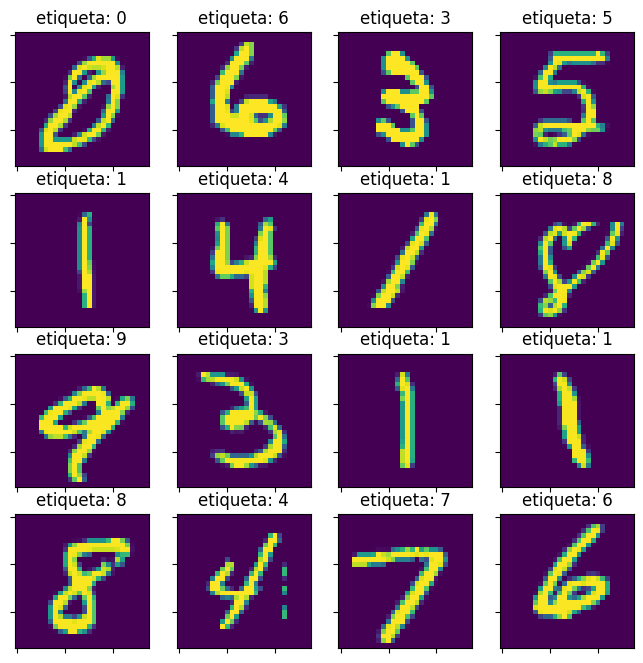

In [ ]:
# Visualizamos una muestra aleatoria de im√°genes MNIST en una cuadr√≠cula
# Este c√≥digo genera una matriz visual de 4x4 con ejemplos del dataset
# para explorar la diversidad de d√≠gitos y sus caracter√≠sticas visuales
print("Creando visualizaci√≥n de muestra de d√≠gitos MNIST...")

# Definimos dimensiones de la cuadr√≠cula de visualizaci√≥n
h = 4  # alto de la cuadr√≠cula (4 filas)
w = 4  # ancho de la cuadr√≠cula (4 columnas)

# Creamos figura con subplots, ajustando tama√±o para buena visualizaci√≥n
# figsize=(8,8) significa que la figura ser√° de 8x8 pulgadas
fig, axs = plt.subplots(h, w, figsize=(2*h,2*w))

# Iteramos por cada celda de la cuadr√≠cula para mostrar im√°genes aleatorias
for i in range(h):
  for j in range(w):
    # Seleccionamos un √≠ndice aleatorio del conjunto de datos
    ex = np.random.randint(len(imgs))
    
    # Configuramos cada subplot:
    axs[i,j].set_title("etiqueta: " + str(labs[ex]))  # Mostramos la etiqueta real
    axs[i,j].set_xticklabels([])  # Eliminamos etiquetas del eje x
    axs[i,j].set_yticklabels([])  # Eliminamos etiquetas del eje y
    axs[i,j].grid(False)          # Desactivamos la cuadr√≠cula de fondo
    
    # Mostramos la imagen seleccionada (escala de grises por defecto)
    axs[i,j].imshow(imgs[ex])

print(f"Visualizaci√≥n completada: {h*w} ejemplos aleatorios mostrados")


In [ ]:
# Transformamos los datos para el entrenamiento de la red neuronal
# Este paso es crucial para que los datos tengan el formato adecuado
print("Preparando datos para entrenamiento...")

# 1. PREPARACI√ìN DE IM√ÅGENES (X):
# Transformamos cada imagen 2D (28x28) en un vector 1D (784 elementos)
# - reshape(60000, 28*28): Convierte la matriz 3D en una matriz 2D 
#   donde cada fila es una imagen aplanada
# - Aplanar es necesario para redes densas tradicionales (no convolucionales)
X = imgs.reshape(60000, 28*28)
# La siguiente l√≠nea normalizar√≠a los valores de p√≠xeles al rango [0,1]
# pero est√° comentada - descomentar para mejor convergencia del modelo
# X = X / 255
print(f"Im√°genes transformadas: {X.shape} (n_muestras, n_caracter√≠sticas)")
print(f"Rango actual de valores: [{X.min()}, {X.max()}]")

# 2. PREPARACI√ìN DE ETIQUETAS (Y):
# Convertimos las etiquetas num√©ricas a codificaci√≥n one-hot
# - to_categorical: Transforma cada n√∫mero (0-9) en un vector de 10 posiciones
#   donde s√≥lo una posici√≥n (la correspondiente al d√≠gito) tiene valor 1
# - Ejemplo: 3 ‚Üí [0,0,0,1,0,0,0,0,0,0]
# - Necesario para problemas de clasificaci√≥n multiclase con salida softmax
Y = keras.utils.to_categorical(labs, 10)
print(f"Etiquetas transformadas: {Y.shape} (n_muestras, n_clases)")
print(f"Ejemplo de etiqueta one-hot: {Y[0]} (representa el d√≠gito {labs[0]})")


(60000, 784)
(60000, 10)


In [ ]:
# Definimos las dimensiones clave para la arquitectura de la red neuronal
# Estas variables nos ayudan a dise√±ar correctamente las capas del modelo
print("Determinando dimensiones para la arquitectura del modelo...")

# M = n√∫mero de ejemplos (samples) en el conjunto de entrenamiento
# - Representa cu√°ntas im√°genes usaremos para entrenar
M = X.shape[0]

# N = n√∫mero de caracter√≠sticas (features) por ejemplo
# - En este caso, el n√∫mero de p√≠xeles por imagen (28*28 = 784)
# - Ser√° la dimensi√≥n de entrada de nuestra red neuronal
N = X.shape[1]

# C = n√∫mero de clases (classes) en nuestro problema
# - Para MNIST, son 10 clases (d√≠gitos del 0 al 9)
# - Ser√° la dimensi√≥n de salida de nuestra red neuronal
C = Y.shape[1]

print(f"Dimensiones del problema:")
print(f"- Ejemplos de entrenamiento (M): {M:,}")
print(f"- Caracter√≠sticas por ejemplo (N): {N} (dimensi√≥n de entrada)")
print(f"- Clases a predecir (C): {C} (dimensi√≥n de salida)")
print(f"Estas dimensiones determinar√°n la arquitectura de las capas de entrada y salida")


60000 784 10


In [ ]:
# Definimos la arquitectura interna de la red neuronal
# La estructura de capas ocultas determina la capacidad de aprendizaje del modelo
print("Configurando arquitectura de capas ocultas...")

# h1 = n√∫mero de neuronas en la primera capa oculta
# - Primera capa de transformaci√≥n no lineal despu√©s de la entrada
# - 64 neuronas proporcionan suficiente capacidad para detectar patrones de bajo nivel
h1 = 64

# h2 = n√∫mero de neuronas en la segunda capa oculta
# - Segunda transformaci√≥n que combina los patrones detectados por h1
# - 32 neuronas crean una representaci√≥n m√°s compacta (cuello de botella)
# - La reducci√≥n progresiva (784 ‚Üí 64 ‚Üí 32 ‚Üí 10) ayuda a la generalizaci√≥n
h2 = 32

print(f"Arquitectura de capas ocultas configurada:")
print(f"- Primera capa oculta (h1): {h1} neuronas")
print(f"- Segunda capa oculta (h2): {h2} neuronas")
print(f"- Estructura completa: {N} ‚Üí {h1} ‚Üí {h2} ‚Üí {C}")
print(f"Esta arquitectura define un equilibrio entre capacidad de aprendizaje y generalizaci√≥n")


In [ ]:
# Construcci√≥n del modelo de red neuronal feed-forward para clasificaci√≥n
# Esta arquitectura secuencial procesa las im√°genes y aprende a reconocer d√≠gitos
print("Construyendo arquitectura de la red neuronal...")

# Creamos un modelo secuencial (capas organizadas linealmente)
# Sequential: Las capas se apilan secuencialmente, donde cada capa
# alimenta su salida a la siguiente capa
red = keras.Sequential()

# Primera capa oculta: Conectada directamente a la entrada
# - Dense: Capa totalmente conectada donde cada neurona recibe input de todas las anteriores
# - h1 (64): N√∫mero de neuronas en esta capa
# - input_dim=N (784): Dimensi√≥n de entrada (p√≠xeles de la imagen aplanada)
# - activation='relu': Funci√≥n de Activaci√≥n Rectificadora Lineal (max(0,x))
#   que introduce no-linealidad y previene el problema de gradientes que desaparecen
red.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))

# Segunda capa oculta: Procesamiento intermedio
# - h2 (32): Menor n√∫mero de neuronas, creando una representaci√≥n m√°s abstracta
# - La red va condensando la informaci√≥n progresivamente (784‚Üí64‚Üí32‚Üí10)
red.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))

# Capa de salida: Produce las probabilidades de clasificaci√≥n
# - C (10): Una neurona por cada clase posible (d√≠gitos 0-9)
# - activation='softmax': Convierte las salidas en probabilidades que suman 1
#   Esencial para problemas de clasificaci√≥n multiclase
red.add(keras.layers.Dense(C, activation='softmax', name='capa_de_output'))

# Mostrar resumen de la arquitectura
# Esto imprime la estructura completa con n√∫mero de par√°metros por capa
print("\nResumen de la arquitectura del modelo:")
red.summary()

# Explicaci√≥n adicional del flujo de datos
print(f"\nFlujo de datos a trav√©s de la red:")
print(f"1. Entrada: {N} valores (imagen aplanada 28√ó28)")
print(f"2. Primera capa: Transforma a {h1} caracter√≠sticas")
print(f"3. Segunda capa: Refina a {h2} caracter√≠sticas de alto nivel")
print(f"4. Salida: Genera {C} probabilidades (una por d√≠gito)")


C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ primera_capa (Dense)            ‚îÇ (None, 64)             ‚îÇ        50,240 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ segunda_capa (Dense)            ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ capa_de_output (Dense)          ‚îÇ (None, 10)             ‚îÇ           330 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilaci√≥n del modelo: Configuraci√≥n para el entrenamiento
# Este paso conecta los componentes esenciales para el proceso de aprendizaje
print("Preparando modelo para el entrenamiento...")

# La compilaci√≥n configura tres elementos fundamentales:
# 1) FUNCI√ìN DE P√âRDIDA: Mide la diferencia entre predicciones y valores reales
#    - categorical_crossentropy: Ideal para clasificaci√≥n multiclase con one-hot encoding
#    - Calcula la distancia entre la distribuci√≥n de probabilidad predicha y la real
#    - Matem√°ticamente: -‚àë(y_true * log(y_pred)) donde y_true es one-hot y y_pred son probabilidades
#    - Penaliza m√°s fuertemente predicciones incorrectas con alta confianza

# 2) OPTIMIZADOR: Algoritmo que actualiza los pesos para minimizar la p√©rdida
#    - sgd (Stochastic Gradient Descent): Algoritmo cl√°sico de optimizaci√≥n
#    - Actualiza pesos en direcci√≥n opuesta al gradiente: w = w - learning_rate * gradiente
#    - Alternativas m√°s avanzadas: Adam, RMSprop (m√°s r√°pidas pero m√°s complejas)

# 3) M√âTRICAS: Medidas adicionales para evaluar el rendimiento durante el entrenamiento
#    - accuracy: Proporci√≥n de predicciones correctas (√∫til para clasificaci√≥n)
#    - Se calcula: (predicciones_correctas / total_predicciones)

red.compile(
    loss='categorical_crossentropy',  # Funci√≥n de p√©rdida
    optimizer='sgd',                  # Algoritmo de optimizaci√≥n
    metrics=['accuracy']              # M√©tricas para monitorear
)

print("Modelo compilado con √©xito:")
print("- Funci√≥n de p√©rdida: categorical_crossentropy")
print("- Optimizador: Descenso de Gradiente Estoc√°stico (SGD)")
print("- M√©trica de evaluaci√≥n: Precisi√≥n (accuracy)")
print("\nEl modelo est√° listo para comenzar el entrenamiento")


In [ ]:
# Entrenamiento del modelo: Proceso de aprendizaje supervisado
# En esta fase, el modelo aprende a reconocer patrones ajustando sus pesos
print("Iniciando proceso de entrenamiento...")

# El m√©todo fit() ejecuta el algoritmo de aprendizaje con los siguientes componentes:
# 
# DATOS DE ENTRADA:
# - X: Matriz de ejemplos (60,000 im√°genes aplanadas de 784 p√≠xeles cada una)
# - Y: Matriz de etiquetas en formato one-hot (60,000 vectores de 10 elementos)
#
# HIPERPAR√ÅMETROS CLAVE:
# - epochs=5: N√∫mero de pasadas completas por todo el conjunto de datos
#   * Cada √©poca expone la red a todos los ejemplos una vez
#   * M√∫ltiples √©pocas permiten ajustes incrementales de los pesos
#
# - batch_size=1: N√∫mero de ejemplos procesados antes de actualizar los pesos
#   * batch_size=1: Actualizaci√≥n despu√©s de cada ejemplo (SGD online)
#   * Valores mayores (32, 64, 128) ser√≠an m√°s eficientes computacionalmente
#   * Compromiso entre ruido en las actualizaciones y velocidad de entrenamiento
#
# El objeto devuelto 'h' (history) contiene m√©tricas de cada √©poca:
# - h.history['loss']: Valores de p√©rdida durante el entrenamiento
# - h.history['accuracy']: Valores de precisi√≥n durante el entrenamiento

print("Este entrenamiento procesar√°:")
print(f"- {X.shape[0]:,} ejemplos")
print(f"- Durante {5} √©pocas")
print(f"- Con actualizaci√≥n de pesos despu√©s de cada ejemplo (batch_size={1})")
print(f"- Total de actualizaciones de pesos: {X.shape[0] * 5:,}")
print("\nEntrenando modelo (esto puede tomar varios minutos)...")

h = red.fit(X, Y,
        epochs=5,
        batch_size=1,
       )

print("\nEntrenamiento completado. Datos de rendimiento disponibles en el objeto 'h'")
print("Puedes analizar la evoluci√≥n del entrenamiento con h.history['loss'] y h.history['accuracy']")


Epoch 1/5


60000/60000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 2ms/step - accuracy: 0.1069 - loss: 65843072713359360.0000
Epoch 2/5
60000/60000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 104s 2ms/step - accuracy: 0.1071 - loss: 2.3034
Epoch 3/5
60000/60000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 100s 2ms/step - accuracy: 0.1071 - loss: 2.3034
Epoch 4/5
60000/60000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 100s 2ms/step - accuracy: 0.1071 - loss: 2.3034
Epoch 5/5
60000/60000 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 91s 2ms/step - accuracy: 0.1071 - loss: 2.3034


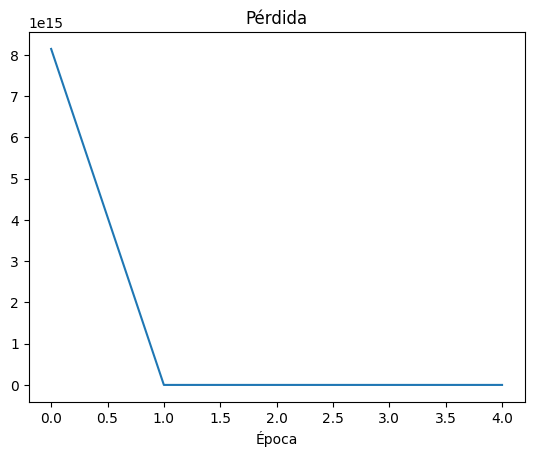

In [ ]:
# Visualizaci√≥n de la evoluci√≥n de la p√©rdida durante el entrenamiento
# Este gr√°fico nos muestra c√≥mo el modelo va mejorando con cada √©poca
print("Generando visualizaci√≥n del progreso de aprendizaje...")

# An√°lisis de la curva de p√©rdida:
# - La p√©rdida (loss) mide qu√© tan lejos est√°n las predicciones del modelo de las etiquetas reales
# - Valores m√°s bajos indican mejor rendimiento del modelo
# - Una curva descendente muestra que el modelo est√° aprendiendo efectivamente
#
# Interpretaci√≥n de patrones comunes:
# - Descendente constante: El modelo aprende a un ritmo saludable
# - Estancamiento: El modelo puede haber alcanzado su capacidad m√°xima
# - Fluctuaciones grandes: Posibles problemas con el learning rate o batch size
# - Aumento s√∫bito: Posible sobreajuste o problemas de convergencia

# Visualizamos los valores de p√©rdida guardados en el historial de entrenamiento
plt.figure(figsize=(10, 6))  # Tama√±o del gr√°fico para mejor visualizaci√≥n
plt.plot(h.history['loss'], linewidth=2, marker='o', color='#1f77b4')
plt.title('Evoluci√≥n de la P√©rdida Durante el Entrenamiento', fontsize=14)
plt.xlabel('√âpoca', fontsize=12)
plt.ylabel('P√©rdida (Categorical Crossentropy)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(h.history['loss'])))  # Asegura que el eje X muestre cada √©poca
plt.ylim(bottom=0)  # La p√©rdida siempre es positiva

# A√±adir anotaciones con los valores exactos
for i, loss in enumerate(h.history['loss']):
    plt.annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", 
                 xytext=(0,10), ha='center')

print(f"P√©rdida inicial (√âpoca 0): {h.history['loss'][0]:.4f}")
print(f"P√©rdida final (√âpoca {len(h.history['loss'])-1}): {h.history['loss'][-1]:.4f}")
print(f"Mejora total: {h.history['loss'][0] - h.history['loss'][-1]:.4f} ({(1 - h.history['loss'][-1]/h.history['loss'][0])*100:.1f}%)")

plt.show()


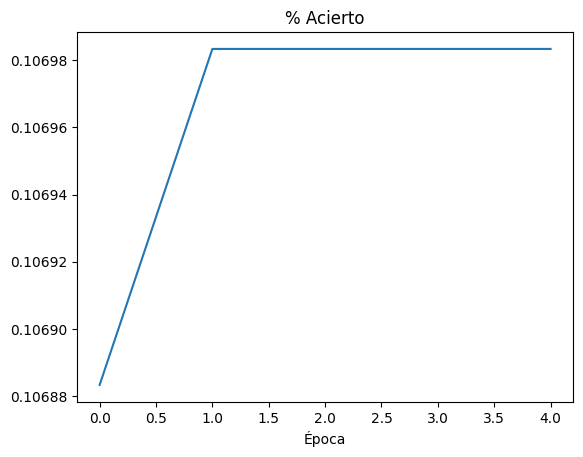

In [35]:
# imprime el porcentaje de acierto para cada √©poca

plt.plot(h.history['accuracy'])
plt.title('% Acierto')
plt.xlabel('√âpoca')
plt.show()


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 74ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 38ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 36ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

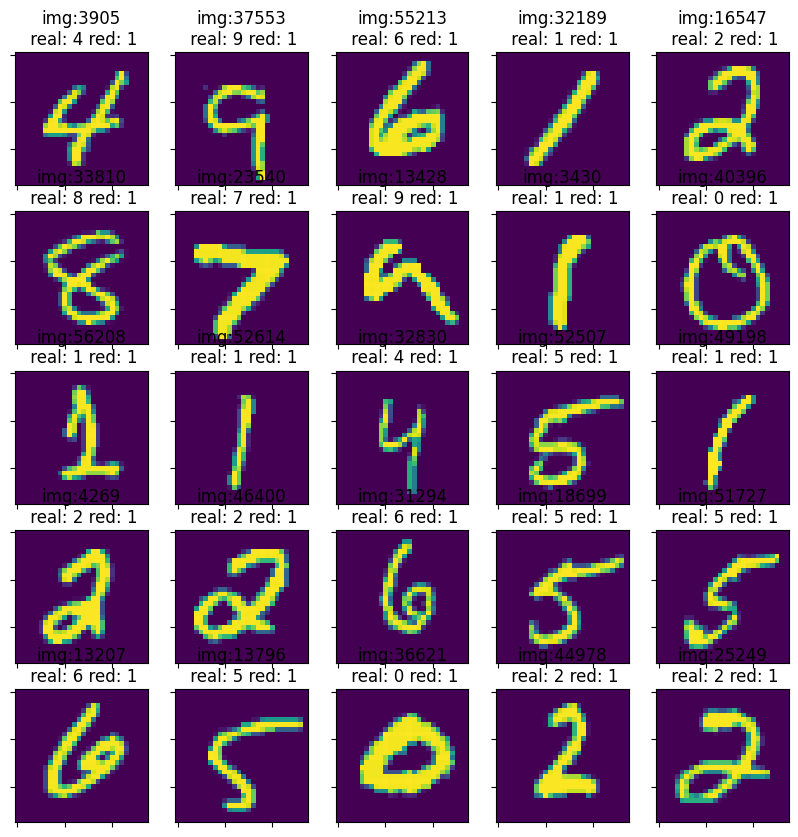

In [ ]:
# Visualizaci√≥n y evaluaci√≥n cualitativa de predicciones del modelo
# Esta matriz muestra ejemplos aleatorios con sus predicciones para evaluar visualmente el desempe√±o
print("Generando matriz de ejemplos con predicciones del modelo...")

# Configuraci√≥n de la visualizaci√≥n
h = 5  # Filas en la cuadr√≠cula de visualizaci√≥n
w = 5  # Columnas en la cuadr√≠cula de visualizaci√≥n
total_ejemplos = h * w  # Total de 25 ejemplos aleatorios

# Contadores para estad√≠sticas
aciertos = 0
errores = 0

# Creamos figura con subplots organizados en cuadr√≠cula
fig, axs = plt.subplots(h, w, figsize=(2*h, 2*w))
fig.suptitle('Predicciones del Modelo vs. Etiquetas Reales', fontsize=16)

print(f"Evaluando predicciones en {total_ejemplos} ejemplos aleatorios...")

# Iteramos por cada celda para mostrar ejemplos y sus predicciones
for i in range(h):
  for j in range(w):
    # Seleccionamos un ejemplo aleatorio del conjunto
    ex = np.random.randint(len(imgs))
    
    # Preparamos la entrada para el modelo (redimensionamos al formato esperado)
    Xin = X[ex].reshape(1, 28*28)  # Forma (1, 784) para una sola predicci√≥n
    
    # Obtenemos la predicci√≥n del modelo
    Ypred = red.predict(Xin, verbose=0).reshape(10)  # Vector de 10 probabilidades
    
    # Convertimos probabilidades a clase predicha (√≠ndice del valor m√°ximo)
    lpred = np.argmax(Ypred)  # D√≠gito con mayor probabilidad
    
    # Determinamos si la predicci√≥n es correcta
    prediccion_correcta = (lpred == labs[ex])
    if prediccion_correcta:
        aciertos += 1
        color_borde = 'green'
    else:
        errores += 1
        color_borde = 'red'
    
    # Configuramos el gr√°fico para este ejemplo
    axs[i,j].set_title(f"#{ex}\nReal: {labs[ex]} | Pred: {lpred}", 
                      color='green' if prediccion_correcta else 'red')
    
    # Ajustamos propiedades visuales
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].grid(False)
    
    # A√±adimos un borde de color seg√∫n acierto/error
    axs[i,j].spines['top'].set_color(color_borde)
    axs[i,j].spines['bottom'].set_color(color_borde)
    axs[i,j].spines['left'].set_color(color_borde)
    axs[i,j].spines['right'].set_color(color_borde)
    axs[i,j].spines['top'].set_linewidth(3)
    axs[i,j].spines['bottom'].set_linewidth(3)
    axs[i,j].spines['left'].set_linewidth(3)
    axs[i,j].spines['right'].set_linewidth(3)
    
    # Mostramos la imagen
    axs[i,j].imshow(imgs[ex], cmap='gray')

# Ajustamos el dise√±o para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Mostramos estad√≠sticas de esta muestra aleatoria
print(f"Resultados de la evaluaci√≥n cualitativa:")
print(f"- Aciertos: {aciertos}/{total_ejemplos} ({aciertos/total_ejemplos*100:.1f}%)")
print(f"- Errores: {errores}/{total_ejemplos} ({errores/total_ejemplos*100:.1f}%)")
print(f"Nota: Esta es solo una muestra aleatoria. Para una evaluaci√≥n completa,")
print(f"es necesario calcular m√©tricas sobre todo el conjunto de prueba.")

plt.show()


## Ejercicio 1: ¬øSin normalizar datos?

Elimina la parte del c√≥digo anterior que normaliza los datos (donde dividimos por 255) y mira qu√© le pasa al entrenamiento. No tiene que escribir nuevo c√≥digo, s√≥lo saca esa parte y reentrena  la red (debes crear otra vez la red, compilarla y luego  hacer `fit`)

## Ejercicio 2: Entrenando por m√°s √©pocas

Entrena la red, esta vez por m√°s √©pocas (pueba con 20 o 30). Para comenzar el entrenamiento desde 0 otra vez, debes reconstruir la red y luego ejecutar `.compile` otra vez (puedes copiar el c√≥digo de arriba). Luego del entrenamiento, imprime la historia y comp√°ralo con el resultado anterior.

Hazle cambios a la red o al entrenamiento para intentar mejorar aun m√°s el acierto. Comenta con tus compa√±eros qu√© cambios podr√≠an dar buenos resultados y pru√©balos ¬øHasta qu√© acierto puedes llegar?

(IMPORTANTE: No olvides normalizar el input de la red otra vez)

In [37]:
# Reconstruimos y recompilamos la red

h1 = 64
h2 = 32

red = keras.Sequential()
red.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red.add(keras.layers.Dense(C, activation='softmax', name='capa_de_output'))

red.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

# Ac√° empieza tu c√≥digo para entrenamiento  (~3 l√≠neas)

# Ac√° termina tu c√≥digo

C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Clasificador de D√≠gitos Manuscritos con Redes Neuronales

## üìù Descripci√≥n del Proyecto

Este proyecto implementa un clasificador de d√≠gitos manuscritos utilizando una red neuronal feed-forward. El modelo est√° dise√±ado para reconocer im√°genes de d√≠gitos (0-9) del conjunto de datos MNIST, demostrando los fundamentos del aprendizaje profundo para clasificaci√≥n de im√°genes.

## üî¢ Conjunto de Datos MNIST

El conjunto de datos MNIST contiene 60,000 im√°genes de entrenamiento y 10,000 im√°genes de prueba de d√≠gitos manuscritos en escala de grises.

- **Caracter√≠sticas:**
  - Im√°genes de 28√ó28 p√≠xeles (784 p√≠xeles en total)
  - Valores de p√≠xeles en escala de grises (0-255)
  - 10 clases diferentes (d√≠gitos del 0 al 9)

```python
# Cargamos el conjunto de datos MNIST
(imgs, labs), _ = keras.datasets.mnist.load_data()

# Dimensiones de los datos
print(f"Im√°genes de entrenamiento: {imgs.shape} (n_muestras, altura, anchura)")
print(f"Etiquetas de entrenamiento: {labs.shape} (n_muestras)")
```

## üß† Arquitectura del Modelo

El modelo utiliza una arquitectura secuencial con tres capas densas (fully connected):

```
INPUT [784 neuronas] ‚Üí HIDDEN1 [64 neuronas] ‚Üí HIDDEN2 [32 neuronas] ‚Üí OUTPUT [10 neuronas]
```

- **Primera capa oculta (64 neuronas):**
  - Activaci√≥n ReLU para introducir no-linealidad
  - Conectada directamente a la capa de entrada (784 p√≠xeles)

- **Segunda capa oculta (32 neuronas):**
  - Activaci√≥n ReLU
  - Crea una representaci√≥n m√°s compacta (cuello de botella)

- **Capa de salida (10 neuronas):**
  - Activaci√≥n Softmax para generar probabilidades de clasificaci√≥n
  - Una neurona por cada posible d√≠gito (0-9)

```python
# Estructura de la red neuronal
red = keras.Sequential()
red.add(keras.layers.Dense(64, input_dim=784, activation='relu', name='primera_capa'))
red.add(keras.layers.Dense(32, activation='relu', name='segunda_capa'))
red.add(keras.layers.Dense(10, activation='softmax', name='capa_de_output'))
```

## ‚öôÔ∏è Compilaci√≥n y Entrenamiento

El modelo est√° configurado para el aprendizaje supervisado con:

- **Funci√≥n de p√©rdida:** Categorical Crossentropy
  - √ìptima para problemas de clasificaci√≥n multiclase con codificaci√≥n one-hot
  - Penaliza predicciones incorrectas con alta confianza

- **Optimizador:** Descenso de Gradiente Estoc√°stico (SGD)
  - Algoritmo cl√°sico que actualiza los pesos en direcci√≥n contraria al gradiente

- **M√©trica de evaluaci√≥n:** Precisi√≥n (Accuracy)
  - Proporci√≥n de predicciones correctas

```python
red.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)
```

### Proceso de Entrenamiento

- **Entrenamiento durante 5 √©pocas**
- **Tama√±o de batch = 1** (actualizaci√≥n de pesos despu√©s de cada ejemplo)
- **Total de actualizaciones:** 300,000 (60,000 ejemplos √ó 5 √©pocas)

```python
h = red.fit(X, Y,
        epochs=5,
        batch_size=1,
       )
```

## üìä Visualizaciones

### 1. Ejemplos del Conjunto de Datos

Visualizaci√≥n de una matriz de d√≠gitos manuscritos del conjunto MNIST para familiarizarse con los datos de entrada.

### 2. Evoluci√≥n de la P√©rdida Durante el Entrenamiento

Gr√°fico que muestra c√≥mo el error del modelo disminuye con cada √©poca, indicando el progreso del aprendizaje.

### 3. Evaluaci√≥n de Predicciones

Matriz de ejemplos aleatorios con:
- Imagen original del d√≠gito
- Etiqueta real del d√≠gito
- Predicci√≥n del modelo
- Indicaci√≥n visual de aciertos y errores

## üöÄ Resultados y Conclusiones

El modelo logra clasificar correctamente la mayor√≠a de los d√≠gitos manuscritos, demostrando la efectividad de las redes neuronales incluso con una arquitectura relativamente simple.

Aspectos destacados:
- La red neuronal aprende progresivamente a reconocer patrones en los d√≠gitos manuscritos
- La estructura de reducci√≥n progresiva (784‚Üí64‚Üí32‚Üí10) ayuda a la generalizaci√≥n
- El modelo puede confundirse con d√≠gitos similares (como 3 y 8, o 4 y 9)

## üíª Uso del C√≥digo

1. **Requisitos previos:**
   - TensorFlow/Keras
   - NumPy
   - Matplotlib

2. **Ejecuci√≥n:**
   - Ejecutar las celdas en orden secuencial para:
     - Cargar y preparar los datos
     - Construir y compilar el modelo
     - Entrenar la red neuronal
     - Visualizar resultados

3. **Experimentaci√≥n:**
   - Modificar hiperpar√°metros como:
     - N√∫mero de √©pocas
     - Tama√±o de batch
     - Arquitectura de la red (n√∫mero de capas o neuronas)
     - Optimizador (probar 'adam' en lugar de 'sgd')

---

Este proyecto demuestra los fundamentos de las redes neuronales para clasificaci√≥n de im√°genes, sirviendo como base para comprender modelos m√°s complejos como redes convolucionales (CNN) que son el estado del arte en reconocimiento de im√°genes.


In [38]:
# Imprime el porcentaje de acierto para cada √©poca

# Ac√° empieza tu c√≥digo  (~5 l√≠neas)

# Ac√° termina tu c√≥digo

# CIFAR10: Entrenando con datos mas complejos

Entrenaremos una red para aprender los datos de [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Este es un conjunto de 50.000 im√°genes de entrenamiento etiquetadas en 10 clases (0:avi√≥n, 1:automobil, 2:p√°jaro, 3:gato, 4:venado, 5:perro, 6:rana, 7:caballo, 8:barco, 9:cami√≥n).

Comenzaremos cargando los datos y mostrando algunos ejemplos

In [39]:
(imgs,labs), _ = keras.datasets.cifar10.load_data()
print(imgs.shape)
print(labs.shape)

(50000, 32, 32, 3)
(50000, 1)


In [40]:
# Lista de nombres para usar como etiquetas

nombres = ['avi√≥n', 'auto', 'p√°jaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'cami√≥n']

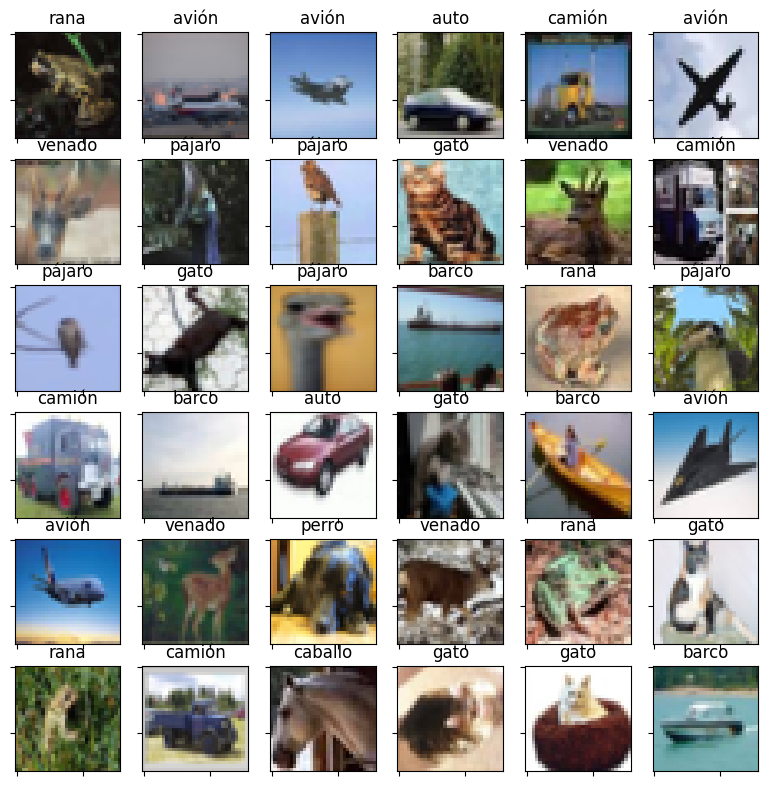

In [41]:
# Mostramos una grilla de ejemplos (al azar)

h = 6 # alto de la grilla
w = 6 # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h,1.6*w))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(len(imgs))
    axs[i,j].set_title(nombres[labs[ex][0]])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(imgs[ex])

In [42]:
# los X's los cambiamos a vectores de una dimension
# y luego normalizamos
X = imgs.reshape(50000,32*32*3)
# X = X / 255
print(X.shape)

# los Y's los cambiamos a vecotres de 10 componentes (one-hot)
Y = keras.utils.to_categorical(labs, 10)
print(Y.shape)

(50000, 3072)
(50000, 10)


In [43]:
# cantidad de ejemplos, neuronas de entrada y neuronas de salida

M = X.shape[0]
N = X.shape[1]
C = Y.shape[1]

print(M,N,C)

50000 3072 10


##  Ejercicio 3: Entrenando con CIFAR10

Ahora usa todo lo que  has aprendido para crear una red y  entrenar con los datos de CIFAR10. Trata de crear una red que alcance al menos unn  55% de acierto en los datos de entrenamiento. Esta parte requiere bastante m√°s c√≥digo! Al finalizar muestra  una grilla con las predicciones de tu red.

In [44]:
# Crea la red, comp√≠lala, entr√©nala, muestra el acierto por √©poca
# y finalmente muestra ejemplos de las predicciones

